C:\python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


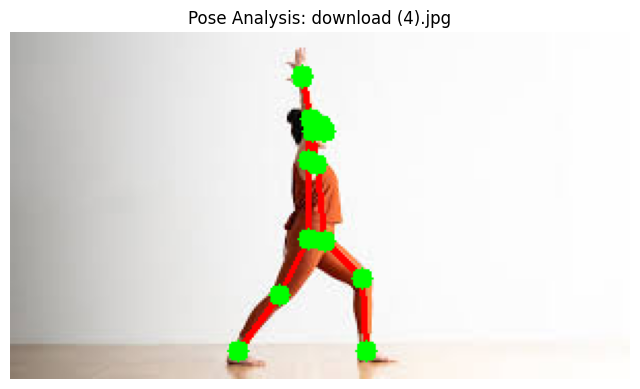


🔹 **POSE FEEDBACK for download (4).jpg** 🔹
➡ Lower your Left Arm slightly for a more balanced pose.
➡ Lower your Right Arm slightly for a more balanced pose.
➡ Try straightening your Left Leg for improved stability.

🔹 **ANGLE DATA** 🔹
📏 Left Arm: 177.0°
📏 Right Arm: 164.7°
📏 Left Leg: 137.3°
📏 Right Leg: 170.7°

🔹 **HEALTH BENEFITS** 🔹
💡 Regular stretching and proper alignment can help improve flexibility and reduce muscle strain.

--------------------------------------------------



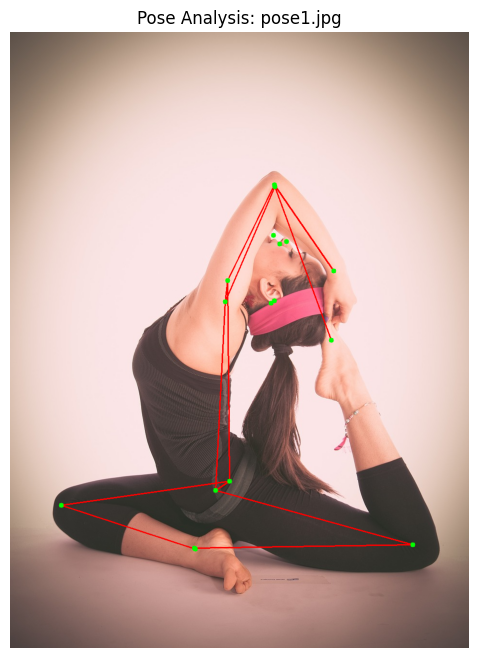


🔹 **POSE FEEDBACK for pose1.jpg** 🔹
➡ Raise your Left Arm higher for better alignment.
➡ Try straightening your Left Leg for improved stability.
➡ Try straightening your Right Leg for improved stability.

🔹 **ANGLE DATA** 🔹
📏 Left Arm: 43.5°
📏 Right Arm: 60.3°
📏 Left Leg: 16.3°
📏 Right Leg: 26.3°

🔹 **HEALTH BENEFITS** 🔹
💡 Regular stretching and proper alignment can help improve flexibility and reduce muscle strain.

--------------------------------------------------



KeyboardInterrupt: 

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import pyttsx3
from torchvision import transforms
from torchvision.models.detection import keypointrcnn_resnet50_fpn

# Initialize Text-to-Speech engine
engine = pyttsx3.init()
engine.setProperty('rate', 150)  # Adjust speech speed

# Load the pre-trained Keypoint R-CNN model
model = keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define keypoint connections (COCO dataset format)
COCO_PERSON_SKELETON = [
    (5, 7), (7, 9),    # Left Arm
    (6, 8), (8, 10),   # Right Arm
    (5, 6),            # Shoulders
    (11, 13), (13, 15),# Left Leg
    (12, 14), (14, 16),# Right Leg
    (11, 12),          # Hips
    (5, 11), (6, 12)   # Torso
]

# Function to calculate angles between three points
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

# Function to analyze pose and provide feedback
def analyze_pose(keypoints):
    feedback_list = []
    angle_data = {}

    # Define joint positions
    joints = {
        "Left Arm": (keypoints[5], keypoints[7], keypoints[9]),
        "Right Arm": (keypoints[6], keypoints[8], keypoints[10]),
        "Left Leg": (keypoints[11], keypoints[13], keypoints[15]),
        "Right Leg": (keypoints[12], keypoints[14], keypoints[16])
    }

    for limb, (a, b, c) in joints.items():
        angle = calculate_angle(a[:2], b[:2], c[:2])
        angle_data[limb] = angle  

        # Provide dynamic corrections based on angles
        if limb in ["Left Arm", "Right Arm"]:
            if angle < 45:
                feedback_list.append(f"Raise your {limb} higher for better alignment.")
            elif angle > 135:
                feedback_list.append(f"Lower your {limb} slightly for a more balanced pose.")

        if limb in ["Left Leg", "Right Leg"]:
            if angle < 140:
                feedback_list.append(f"Try straightening your {limb} for improved stability.")

    # If no feedback is needed, return positive message
    if not feedback_list:
        return ["Great posture! Keep it up."], angle_data

    return feedback_list, angle_data

# Function to provide health benefits based on detected pose
def get_pose_benefits(angles):
    if "Left Leg" in angles and angles["Left Leg"] > 160 and "Right Leg" in angles and angles["Right Leg"] > 160:
        return "It looks like you're doing a standing pose, which improves balance and strengthens leg muscles."

    if "Left Arm" in angles and "Right Arm" in angles:
        if 80 < angles["Left Arm"] < 120 and 80 < angles["Right Arm"] < 120:
            return "Your arms are in a T-pose, which is great for shoulder mobility and posture."

    return "Regular stretching and proper alignment can help improve flexibility and reduce muscle strain."

# Function to load and process image
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Error: Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([transforms.ToTensor()])
    return img, transform(img).to(device)

# Folder containing images (Change this path)
image_folder = r"C:\Users\ASUS\Desktop\projeccct\HumanPoseEstimation\images"  # Change as needed
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Process each image
for image_path in image_files:
    img, img_tensor = load_image(image_path)

    # Perform pose estimation
    with torch.no_grad():
        output = model([img_tensor])

    # Extract keypoints
    keypoints = output[0]['keypoints'][0].cpu().numpy()
    feedback, angles = analyze_pose(keypoints)
    health_benefit = get_pose_benefits(angles)

    # Draw keypoints and skeleton on image
    for partA, partB in COCO_PERSON_SKELETON:
        if keypoints[partA][2] > 0.5 and keypoints[partB][2] > 0.5:
            cv2.line(img, tuple(map(int, keypoints[partA][:2])), tuple(map(int, keypoints[partB][:2])), (255, 0, 0), 2)

    for x, y, conf in keypoints:
        if conf > 0.5:
            cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)

    # Show result for current image
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off") 
    plt.title(f"Pose Analysis: {os.path.basename(image_path)}")
    plt.show()

    # Print feedback in the console
    print(f"\n🔹 **POSE FEEDBACK for {os.path.basename(image_path)}** 🔹")
    for msg in feedback:
        print(f"➡ {msg}")

    # Print angles for better understanding
    print("\n🔹 **ANGLE DATA** 🔹")
    for limb, angle in angles.items():
        print(f"📏 {limb}: {angle:.1f}°")

    print("\n🔹 **HEALTH BENEFITS** 🔹")
    print(f"💡 {health_benefit}")

    # Speak out the feedback and health benefits
    feedback_text = ". ".join(feedback)
    speech_output = f"{feedback_text}. Also, {health_benefit}"
    engine.say(speech_output)
    engine.runAndWait()

    print("\n" + "-"*50 + "\n")  # Separator for readability
